In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Importing the necessary libraries**

In [21]:
import os
import h5py
import numpy as np
from tensorflow.keras import utils
import pylab as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from PIL import Image
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.utils import to_categorical

In [6]:
pip install astroNN

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.2/910.2 kB 53.1 MB/s eta 0:00:00


# Data loading
**Loading the galaxy images,labels,ra,dec and redshift(z) from dataset file h5 that contains multidimensional arrays**

In [2]:
if not os.path.isfile('/content/drive/MyDrive/Galactic_Scholors/Galaxy10_DECals.h5'):
    url = 'https://astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5'
    print("ERROR: download dataset from: ", url)
if os.path.isdir('Galaxy10'):
    import shutil
    shutil.rmtree('Galaxy10')

In [3]:
with h5py.File('/content/drive/MyDrive/Galactic_Scholors/Galaxy10_DECals.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])
    ra = np.array(F['ra'])
    dec = np.array(F['dec'])
    z = np.array(F['redshift'])

print('Data loaded successfully')

#Galaxy10 dataset (17736 images)
#├── Class 0 (1081 images): Disturbed_Galaxies
#├── Class 1 (1853 images): Merging_Galaxies
#├── Class 2 (2645 images): Round_Smooth_Galaxies
#├── Class 3 (2027 images): In-between_Round_Smooth_Galaxies
#├── Class 4 ( 334 images): Cigar_Shaped_Smooth_Galaxies
#├── Class 5 (2043 images): Barred_Spiral_Galaxies
#├── Class 6 (1829 images): Unbarred_Tight_Spiral_Galaxies
#├── Class 7 (2628 images): Unbarred_Loose_Spiral_Galaxies
#├── Class 8 (1423 images): Edge-on_Galaxies_without_Bulge
#└── Class 9 (1873 images): Edge-on_Galaxies_with_Bulge

class_names = ['Disturbed', 'Merging', 'Round_Smooth',
               'In-between_Round_Smooth', 'Cigar_Shaped_Smooth', 'Barred_Spiral',
               'Unbarred_Tight_Spiral', 'Unbarred_Loose_Spiral', 'Edge-on_without_Bulge',
               'Edge-on_with_Bulge']

Data loaded successfully


In [4]:
print('Images shape:',images.shape)

Images shape: (17736, 256, 256, 3)


In [5]:
print('labels:', labels)

labels: [0 0 0 ... 9 9 9]


# Trivial data exploration

**Exploring 10 random galaxy images in the dataset**

Images index to display: [11649 11882 11928  1695 11068 17078   680 15011 12480 17153]


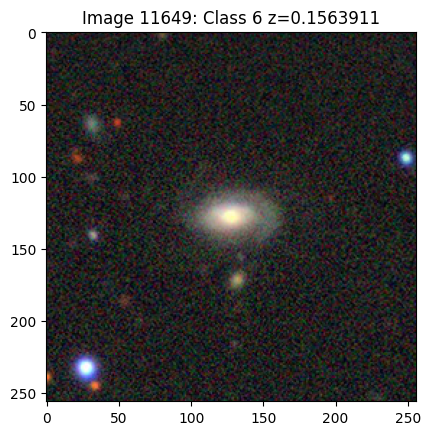

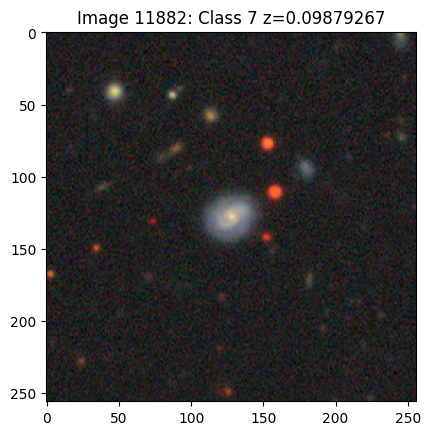

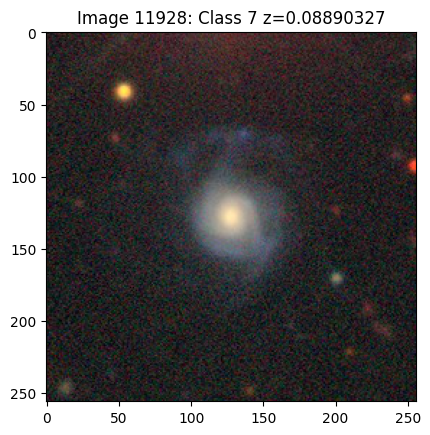

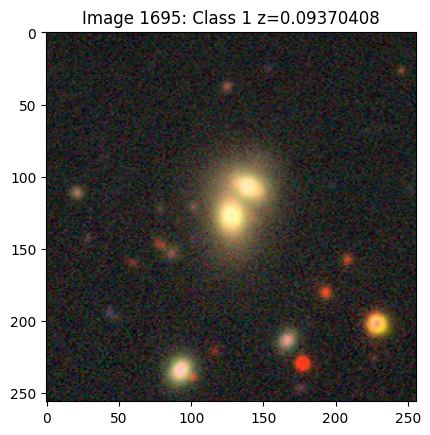

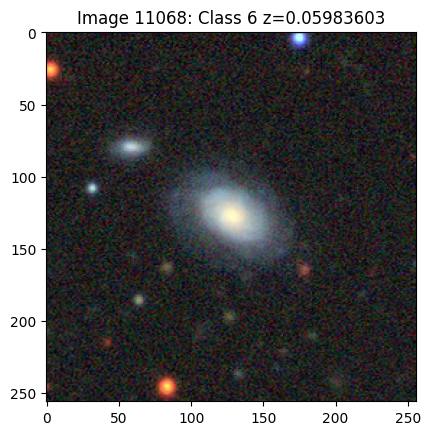

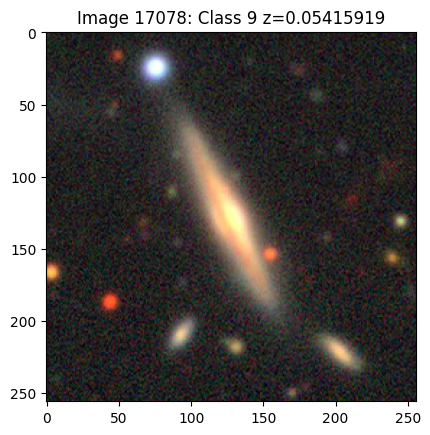

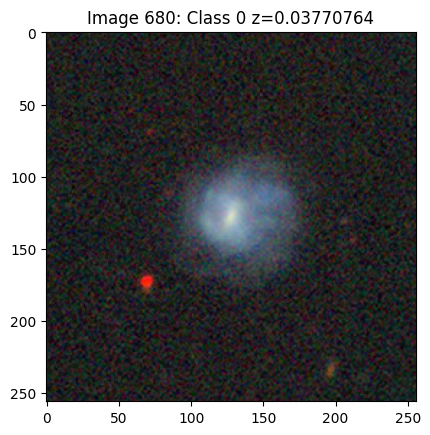

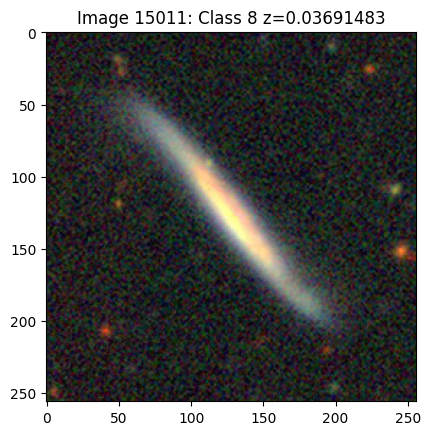

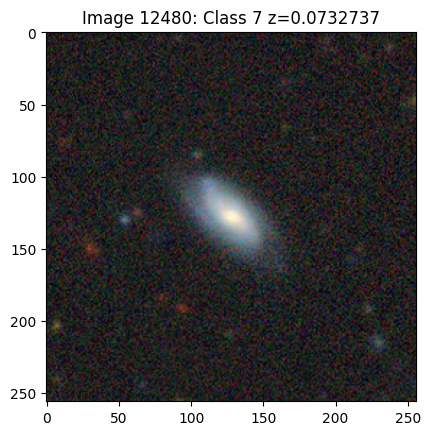

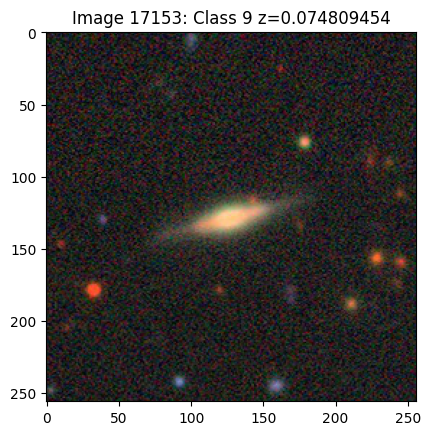

In [12]:
# Exploring 10 random galaxies in the dataset with their corresponding index, class label and redshift(z)
img = None
plt.ion()
samples = np.random.randint(0, labels.shape[0], size=10)
print('Images index to display:', samples)
for i in samples:
    img = plt.imshow(images[i])
    plt.title('Image {}: Class {} z={}'.format(i, labels[i], z[i]))
    plt.draw()
    plt.pause(2.)
plt.close('all')


**Visualizing the distribution of galaxies according to their coordinates(ra,dec) on sky**

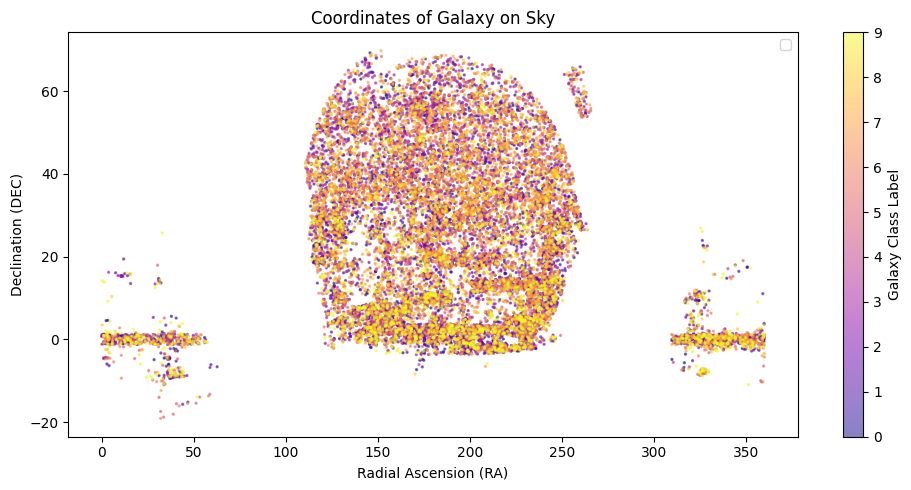

In [13]:
# Scatter plot to visualize the distribution of galaxies according to their coordinates(ra,dec) on sky
plt.figure(figsize = (10,5))
plt.scatter(ra, dec, c = labels, s = 2, cmap = 'plasma', alpha = .5)
cb = plt.colorbar()
cb.set_label('Galaxy Class Label')
plt.title("Coordinates of Galaxy on Sky")
plt.xlabel("Radial Ascension (RA)")
plt.ylabel("Declination (DEC)")
plt.legend()
plt.tight_layout()

**Visualizing the distribution of redshift**

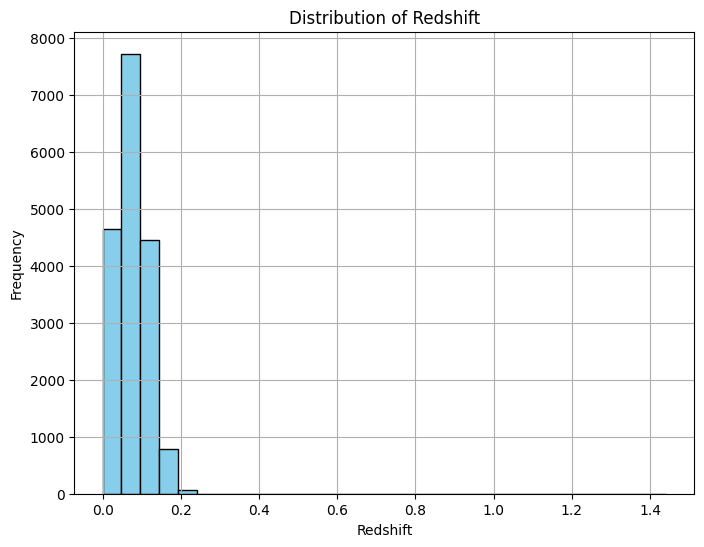

In [14]:
# Plot the distribution of redshift
plt.figure(figsize=(8, 6))
plt.hist(z, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Redshift')
plt.xlabel('Redshift')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

**Converting labels into 10 categorical classes**

In [15]:
# Convert labels into 10 categorical classes
labels_cat = utils.to_categorical(labels, 10)
print('Categorical label:', labels_cat[0])
print('Shape of data structure labels {} and images {}'.format(labels_cat.shape, images.shape))

Categorical label: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Shape of data structure labels (17736, 10) and images (17736, 256, 256, 3)


In [16]:
print(labels_cat)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


**Visualizing the distribution of galaxies across classes**

In [17]:
# Number of galaxies per class
print('Dataset images per class:', np.sum(labels_cat, axis=0))

Dataset images per class: [1081. 1853. 2645. 2027.  334. 2043. 1829. 2628. 1423. 1873.]


<ipython-input-19-477ef4bddc32>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=np.argmax(labels_cat, axis=1), palette='viridis')


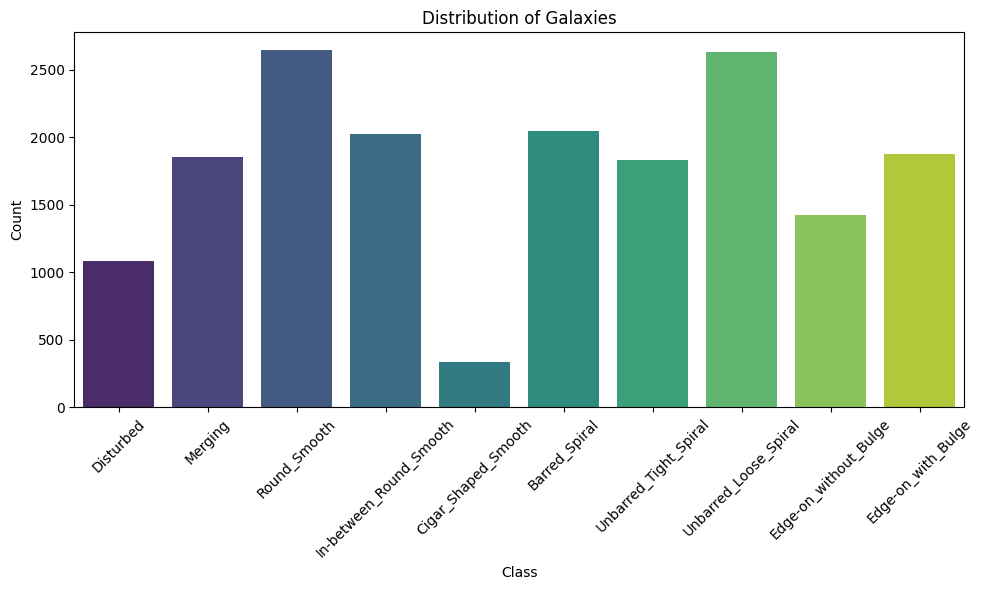

In [19]:
# Create a countplot visualize the distribution of galaxies across classes
plt.figure(figsize=(10, 6))
sns.countplot(x=np.argmax(labels_cat, axis=1), palette='viridis')
plt.title('Distribution of Galaxies')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=np.arange(10), labels=class_names, rotation=45)
plt.tight_layout()
plt.show()



*   According to the countplot the dataset is imbalanced.
*   Therefore in the next steps we will apply a suitable resampling technique and prepare a balanced dataset.
*   Furthermore we will be selecting galaxies with redshift under 0.08 to train the models because of limitations in resolution.









# Dataset resampling

**Filtering the dataset to include galaxies with redshift under 0.08 and create a new balanced dataset using undersampling**

In [22]:
# Step 1: Filter the dataset to include galaxies with redshift under 0.08
filtered_indices = np.where(z < 0.08)[0]
filtered_images = images[filtered_indices]
filtered_labels = labels[filtered_indices]

# Reshape the images array to 2D
num_samples, height, width, channels = filtered_images.shape
reshaped_images = filtered_images.reshape(num_samples, height * width * channels)

# Step 2: Apply undersampling technique
undersampler = RandomUnderSampler()
undersampled_images, undersampled_labels = undersampler.fit_resample(reshaped_images, filtered_labels)

# Check the class distribution after undersampling
undersampled_labels_cat = to_categorical(undersampled_labels, num_classes=10)
class_distribution_after_undersampling = np.sum(undersampled_labels_cat, axis=0)
print("Class distribution after undersampling:", class_distribution_after_undersampling)

Class distribution after undersampling: [234. 234. 234. 234. 234. 234. 234. 234. 234. 234.]


**Visualizing the distribution of galaxies in the new balanced dataset**

<ipython-input-23-33bcd9caf08c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=np.argmax(undersampled_labels_cat, axis=1), palette='viridis')


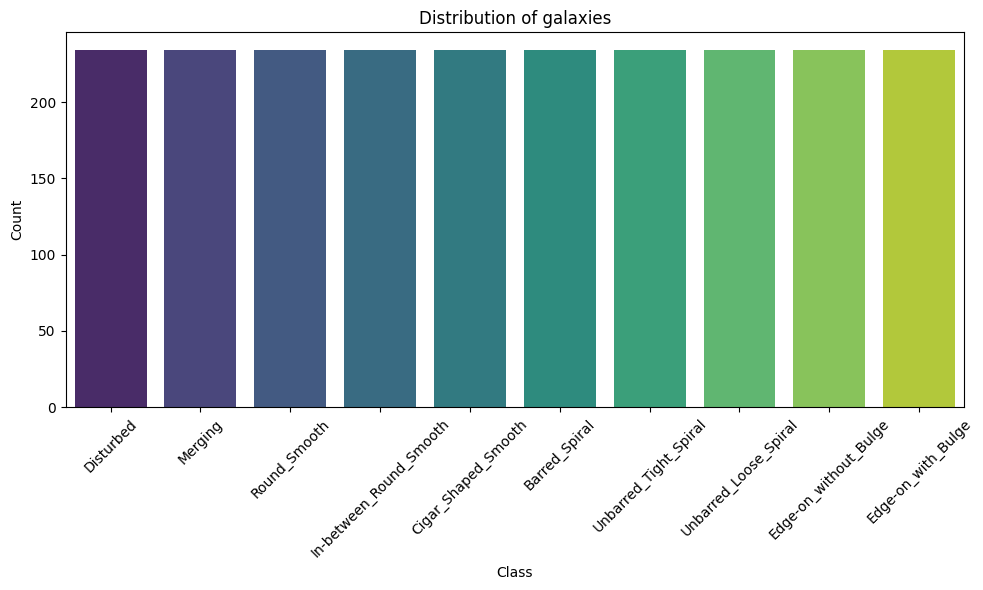

In [23]:
# Create a countplot visualize the distribution of galaxies across classes after fitering by redshift and undersampling
plt.figure(figsize=(10, 6))
sns.countplot(x=np.argmax(undersampled_labels_cat, axis=1), palette='viridis')
plt.title('Distribution of galaxies')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=np.arange(10), labels=class_names, rotation=45)
plt.tight_layout()
plt.show()

# Resampled dataset exploration

**Exploring galaxies from each class in the resampled dataset**

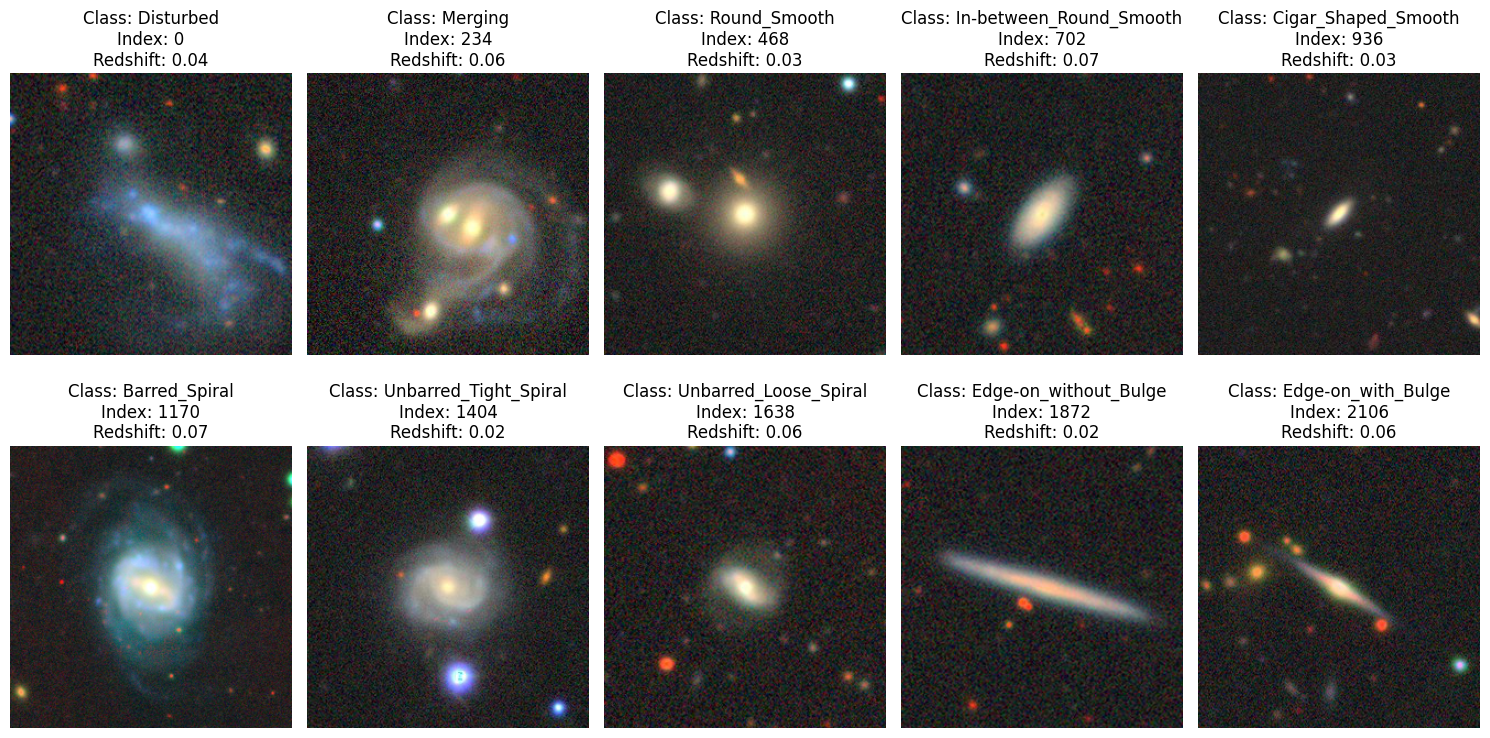

In [24]:
# Create a figure to display one galaxy from each class
plt.figure(figsize=(15, 8))

# Iterate over each class
for i in range(10):
    # Find the index of the first occurrence of the current class in the undersampled labels
    class_index = np.where(undersampled_labels == i)[0][0]

    # Get the index, redshift, and image of the galaxy
    index = class_index
    redshift = z[filtered_indices][class_index]
    image = undersampled_images[class_index].reshape(height, width, channels)

    # Plot the galaxy
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title('Class: {}\nIndex: {}\nRedshift: {:.2f}'.format(class_names[i], index, redshift))
    plt.axis('off')

plt.tight_layout()
plt.show()

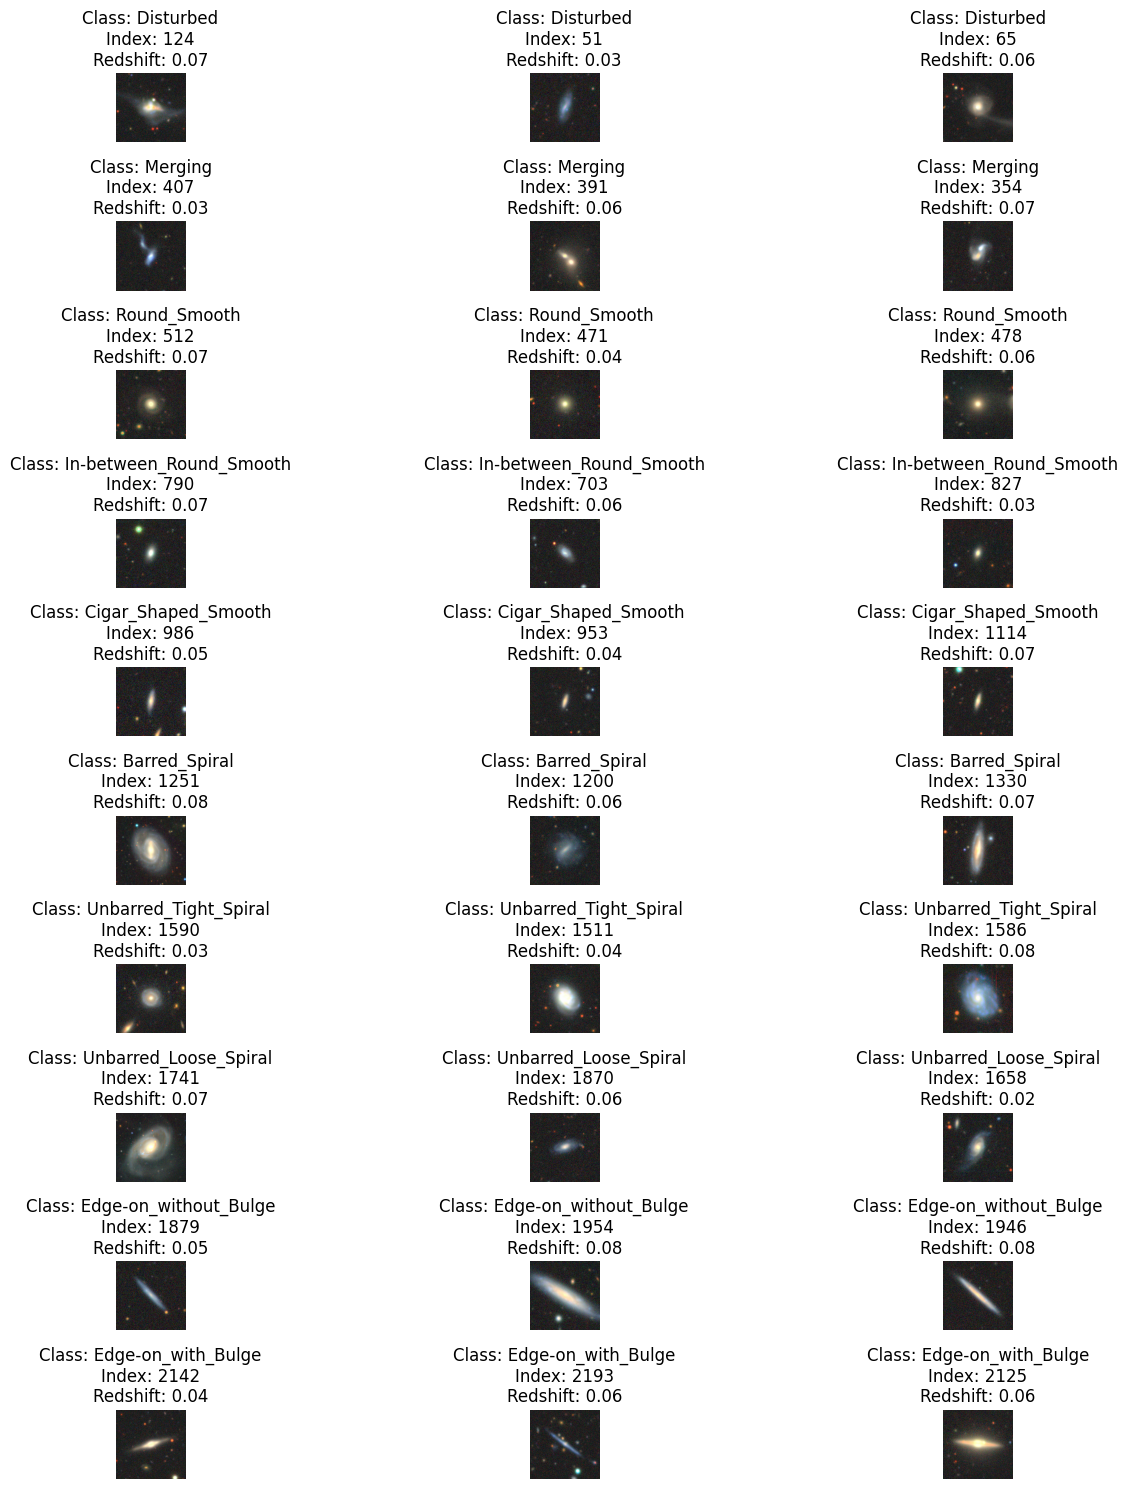

In [25]:
# Create a figure to display three galaxies from each class
plt.figure(figsize=(15, 15))

# Iterate over each class
for i in range(10):
    # Find the indices of all occurrences of the current class in the undersampled labels
    class_indices = np.where(undersampled_labels == i)[0]

    # Randomly select three indices from the class indices
    selected_indices = np.random.choice(class_indices, size=3, replace=False)

    # Iterate over the selected indices
    for j, index in enumerate(selected_indices):
        # Get the index, redshift, and image of the galaxy
        redshift = z[filtered_indices][index]
        image = undersampled_images[index].reshape(height, width, channels)

        # Plot the galaxy
        plt.subplot(10, 3, i * 3 + j + 1)
        plt.imshow(image)
        plt.title('Class: {}\nIndex: {}\nRedshift: {:.2f}'.format(class_names[i], index, redshift))
        plt.axis('off')

plt.tight_layout()
plt.show()

In [26]:
# Reshape undersampled_images to (2340, 256, 256, 3)
x_res = undersampled_images.reshape(-1, 256, 256, 3)
x_res.shape

(2340, 256, 256, 3)

In [27]:
print('Images shape:',x_res.shape)

Images shape: (2340, 256, 256, 3)


In [28]:
y_res = undersampled_labels

In [29]:
print('Labels shape:',y_res.shape)

Labels shape: (2340,)


In [30]:
print('Labels:',y_res)

Labels: [0 0 0 ... 9 9 9]


In [31]:
# One hot encoding the labels
labels_cat_1 = utils.to_categorical(y_res, 10)
print('Categorical label:', labels_cat_1[0])
print('Shape of data structure labels {} and images {}'.format(labels_cat_1.shape, x_res.shape))

Categorical label: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Shape of data structure labels (2340, 10) and images (2340, 256, 256, 3)


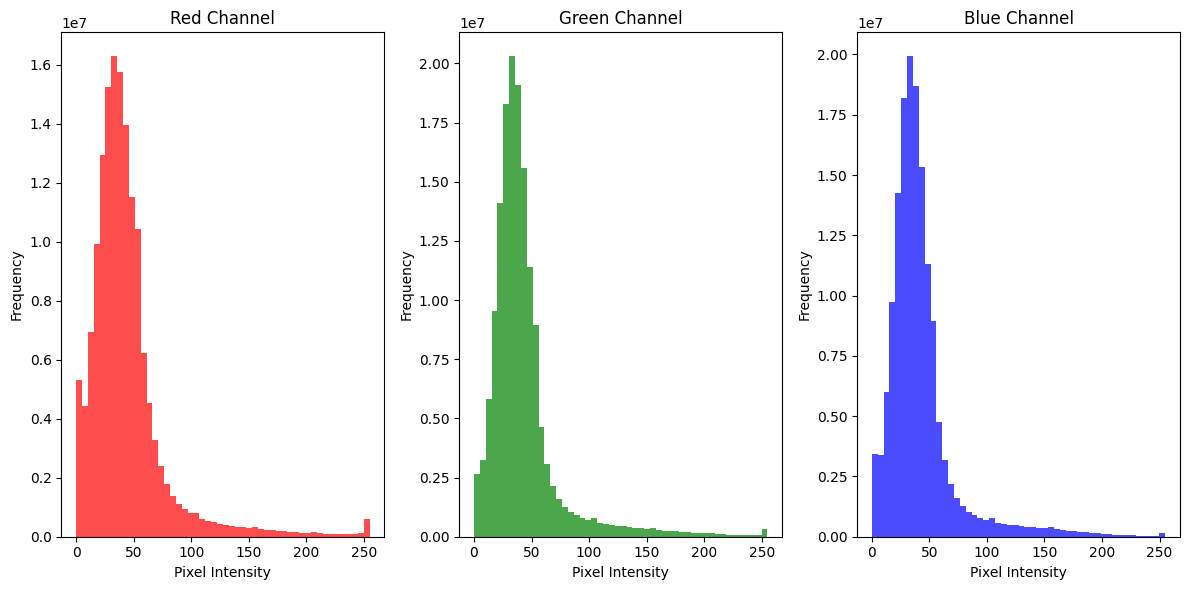

In [32]:
# Plot histograms of pixel intensities for each color channel
plt.figure(figsize=(12, 6))

# Red channel
plt.subplot(1, 3, 1)
plt.hist(x_res[:,:,:,0].flatten(), bins=50, color='red', alpha=0.7)
plt.title('Red Channel')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

# Green channel
plt.subplot(1, 3, 2)
plt.hist(x_res[:,:,:,1].flatten(), bins=50, color='green', alpha=0.7)
plt.title('Green Channel')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

# Blue channel
plt.subplot(1, 3, 3)
plt.hist(x_res[:,:,:,2].flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Blue Channel')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

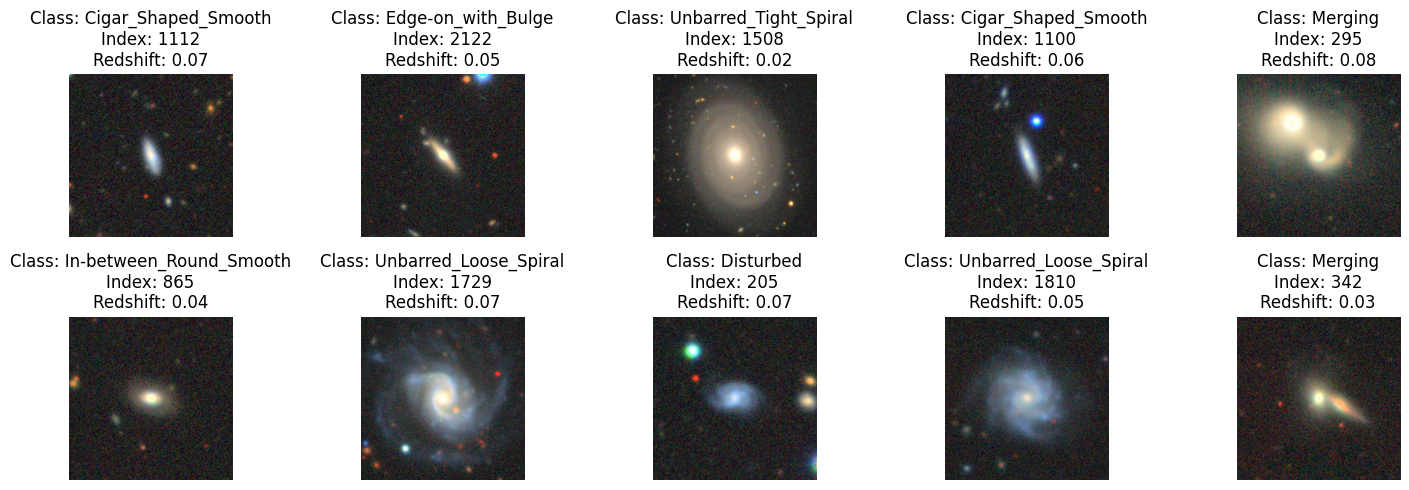

In [33]:
# Create a figure to display 10 random galaxies
plt.figure(figsize=(15, 5))

# Randomly select 10 indices from the undersampled dataset
random_indices = np.random.choice(len(undersampled_labels), size=10, replace=False)

# Iterate over the selected indices
for i, index in enumerate(random_indices):
    # Get the index, redshift, and image of the galaxy
    class_index = undersampled_labels[index]
    redshift = z[filtered_indices][index]
    image = x_res[index]

    # Plot the galaxy
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title('Class: {}\nIndex: {}\nRedshift: {:.2f}'.format(class_names[class_index], index, redshift))
    plt.axis('off')

plt.tight_layout()
plt.show()